In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.calibration import calibration_curve
from scipy import stats
import seaborn as sns
import pymc as pm
import arviz as az

if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using Apple Metal (MPS)')
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using CUDA')
else:
    device = torch.device('cpu')
    print('Using CPU')

print(f'Device: {device}')



Using Apple Metal (MPS)
Device: mps


In [51]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN().to(device)



In [52]:
model_path = '../models/cifar_cnn_model.pth'
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

print('Model loaded successfully!')
print(f'Final test accuracy: {checkpoint["final_test_acc"]:.2f}%')
print(f'Number of epochs trained: {checkpoint["num_epochs"]}')



Model loaded successfully!
Final test accuracy: 77.44%
Number of epochs trained: 20


In [53]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

num_workers = 0 if device.type == 'mps' else 2

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=num_workers)

val_size = 5000
val_indices = torch.randperm(len(testset))[:val_size]
val_subset = torch.utils.data.Subset(testset, val_indices)
valloader = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



In [54]:
def get_predictions(model, dataloader, device, temperature=1.0):
    model.eval()
    all_probs = []
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model(inputs)
            probs = F.softmax(logits / temperature, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            all_probs.append(probs.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    return np.concatenate(all_probs), np.concatenate(all_preds), np.concatenate(all_labels)

probs_val, preds_val, labels_val = get_predictions(model, valloader, device)
probs_test, preds_test, labels_test = get_predictions(model, testloader, device)

print(f'Validation set size: {len(labels_val)}')
print(f'Test set size: {len(labels_test)}')



Validation set size: 5000
Test set size: 10000


In [55]:
class TemperatureScaling(nn.Module):
    def __init__(self):
        super(TemperatureScaling, self).__init__()
        self.temperature = nn.Parameter(torch.ones(1))
    
    def forward(self, logits):
        return logits / self.temperature

def calibrate_temperature(model, valloader, device):
    model.eval()
    logits_list = []
    labels_list = []
    
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model(inputs)
            logits_list.append(logits)
            labels_list.append(labels)
    
    logits = torch.cat(logits_list, dim=0)
    labels = torch.cat(labels_list, dim=0)
    
    temperature_model = TemperatureScaling().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.LBFGS([temperature_model.temperature], lr=0.01, max_iter=10000)
    
    def eval():
        optimizer.zero_grad()
        loss = criterion(temperature_model(logits), labels)
        loss.backward()
        return loss
    
    optimizer.step(eval)
    
    return temperature_model.temperature.item()
calibrated_temp = calibrate_temperature(model, valloader, device)
print("calibrated temperature value:", calibrated_temp)



calibrated temperature value: 2.579084873199463


In [56]:
def get_logits_and_labels(model, dataloader, device):
    model.eval()
    logits_list = []
    labels_list = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model(inputs)
            logits_list.append(logits.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    
    return np.concatenate(logits_list), np.concatenate(labels_list)

logits_val, labels_val_np = get_logits_and_labels(model, valloader, device)

print(f'Validation logits shape: {logits_val.shape}')
print(f'Validation labels shape: {labels_val_np.shape}')


Validation logits shape: (5000, 10)
Validation labels shape: (5000,)


In [57]:
import pymc as pm

with pm.Model() as bayesian_model:
    T = pm.Gamma('temperature', alpha=4, beta=4/calibrated_temp)
    scaled_logits = logits_val / T
    y = pm.Categorical('y', p=pm.math.softmax(scaled_logits, axis=-1), observed=labels_val_np)

    trace = pm.sample(4000, tune=1000, return_inferencedata=True, 
                     target_accept=0.95, random_seed=42)

    

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temperature]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 133 seconds.


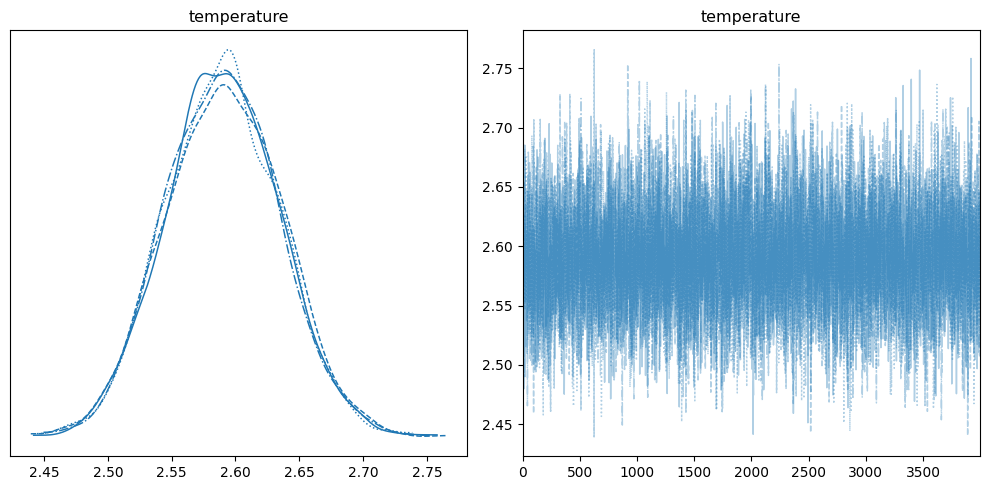

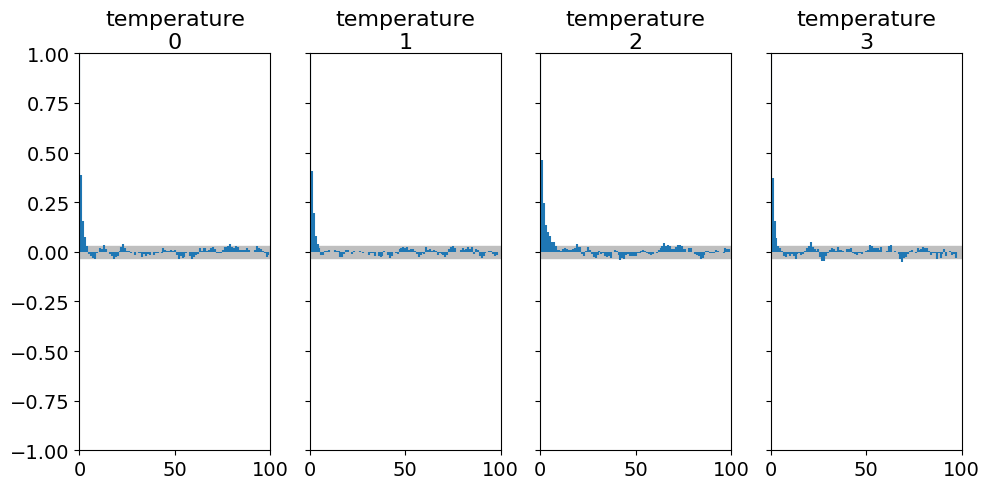

In [58]:
import matplotlib.pyplot as plt
import arviz as az

# Assuming 'trace' is already defined

# Define a larger figure size (e.g., 12 inches wide by 8 inches tall)
large_figsize = (10, 5)

## Trace plots

# Pass the figsize argument to az.plot_trace
az.plot_trace(trace, var_names=['temperature'], figsize=large_figsize)
plt.tight_layout()
plt.show()


## ACF plots

# Pass the figsize argument to az.plot_autocorr
az.plot_autocorr(trace, var_names=['temperature'], max_lag=100, figsize=large_figsize)
plt.tight_layout()
plt.show()

In [ ]:
print('Running Prior Predictive Check...')
print(f'Point estimate temperature: {calibrated_temp:.4f}')

with pm.Model() as prior_model:
    T_prior = pm.Gamma('temperature', alpha=4, beta=4/calibrated_temp)
    scaled_logits_prior = logits_val / T_prior
    y_prior = pm.Categorical('y', p=pm.math.softmax(scaled_logits_prior, axis=-1))

prior_predictive = pm.sample_prior_predictive(samples=500, model=prior_model, random_seed=42)


Sampling: [temperature, y]


Running Prior Predictive Check...
Point estimate temperature: 2.5791


In [ ]:
print('Running Posterior Predictive Check...')

with bayesian_model:
    posterior_predictive = pm.sample_posterior_predictive(trace, random_seed=42)

print('Posterior predictive sampling completed!')


Sampling: [y]


Output()

Running Posterior Predictive Check...


Posterior predictive sampling completed!


In [61]:
def compute_accuracy(predicted_labels, true_labels):
    return (predicted_labels == true_labels).mean()

def compute_class_distribution(labels, n_classes=10):
    labels = np.array(labels).flatten().astype(int)
    dist = np.zeros(n_classes)
    unique, counts = np.unique(labels, return_counts=True)
    for u, c in zip(unique, counts):
        if 0 <= u < n_classes:
            dist[u] = c
    return dist / len(labels)

n_classes = 10
observed_dist = compute_class_distribution(labels_val_np, n_classes)

prior_pred_samples = prior_predictive['prior']['y'].values
posterior_pred_samples = posterior_predictive['posterior_predictive']['y'].values

print(f"Prior pred samples shape: {prior_pred_samples.shape}")
print(f"Posterior pred samples shape: {posterior_pred_samples.shape}")
print(f"Labels shape: {labels_val_np.shape}")

prior_accuracies = []
posterior_accuracies = []
prior_dists = []
posterior_dists = []

n_val_samples = len(labels_val_np)

if len(prior_pred_samples.shape) == 3:
    n_samples = min(100, prior_pred_samples.shape[1])
    for i in range(n_samples):
        sample_labels = prior_pred_samples[0, i, :]
        prior_accuracies.append(compute_accuracy(sample_labels, labels_val_np))
        prior_dists.append(compute_class_distribution(sample_labels, n_classes))
elif len(prior_pred_samples.shape) == 2:
    if prior_pred_samples.shape[1] == n_val_samples:
        n_samples = min(100, prior_pred_samples.shape[0])
        for i in range(n_samples):
            sample_labels = prior_pred_samples[i, :]
            prior_accuracies.append(compute_accuracy(sample_labels, labels_val_np))
            prior_dists.append(compute_class_distribution(sample_labels, n_classes))

if len(posterior_pred_samples.shape) == 3:
    n_chains = posterior_pred_samples.shape[0]
    n_samples_per_chain = min(25, posterior_pred_samples.shape[1])
    for chain in range(n_chains):
        for i in range(n_samples_per_chain):
            sample_labels = posterior_pred_samples[chain, i, :]
            posterior_accuracies.append(compute_accuracy(sample_labels, labels_val_np))
            posterior_dists.append(compute_class_distribution(sample_labels, n_classes))
elif len(posterior_pred_samples.shape) == 2:
    if posterior_pred_samples.shape[1] == n_val_samples:
        n_samples = min(100, posterior_pred_samples.shape[0])
        for i in range(n_samples):
            sample_labels = posterior_pred_samples[i, :]
            posterior_accuracies.append(compute_accuracy(sample_labels, labels_val_np))
            posterior_dists.append(compute_class_distribution(sample_labels, n_classes))

prior_dists = np.array(prior_dists)
posterior_dists = np.array(posterior_dists)

print('\nPredictive Check Statistics:')
print(f'Observed accuracy: {compute_accuracy(labels_val_np, labels_val_np):.4f}')
print(f'Prior predictive accuracy - Mean: {np.mean(prior_accuracies):.4f}, Std: {np.std(prior_accuracies):.4f}')
print(f'Posterior predictive accuracy - Mean: {np.mean(posterior_accuracies):.4f}, Std: {np.std(posterior_accuracies):.4f}')


Prior pred samples shape: (1, 500, 5000)
Posterior pred samples shape: (4, 2000, 5000)
Labels shape: (5000,)

Predictive Check Statistics:
Observed accuracy: 1.0000
Prior predictive accuracy - Mean: 0.6874, Std: 0.0749
Posterior predictive accuracy - Mean: 0.0986, Std: 0.0022


In [62]:
temp_samples_from_trace = trace.posterior['temperature'].values.flatten()
mean_temp_bayesian = np.mean(temp_samples_from_trace)

print(f'\nTemperature Comparison:')
print(f'  Point estimate (L-BFGS): {calibrated_temp:.4f}')
print(f'  Posterior mean (MCMC): {mean_temp_bayesian:.4f}')
print(f'  Posterior std: {np.std(temp_samples_from_trace):.4f}')

hdi = az.hdi(trace, var_names=['temperature'])
print(f'  95% HDI: [{hdi.temperature.values[0]:.4f}, {hdi.temperature.values[1]:.4f}]')
print(f'  Point estimate in HDI: {hdi.temperature.values[0] <= calibrated_temp <= hdi.temperature.values[1]}')



Temperature Comparison:
  Point estimate (L-BFGS): 2.5791
  Posterior mean (MCMC): 2.5902
  Posterior std: 0.0446
  95% HDI: [2.5105, 2.6768]
  Point estimate in HDI: True


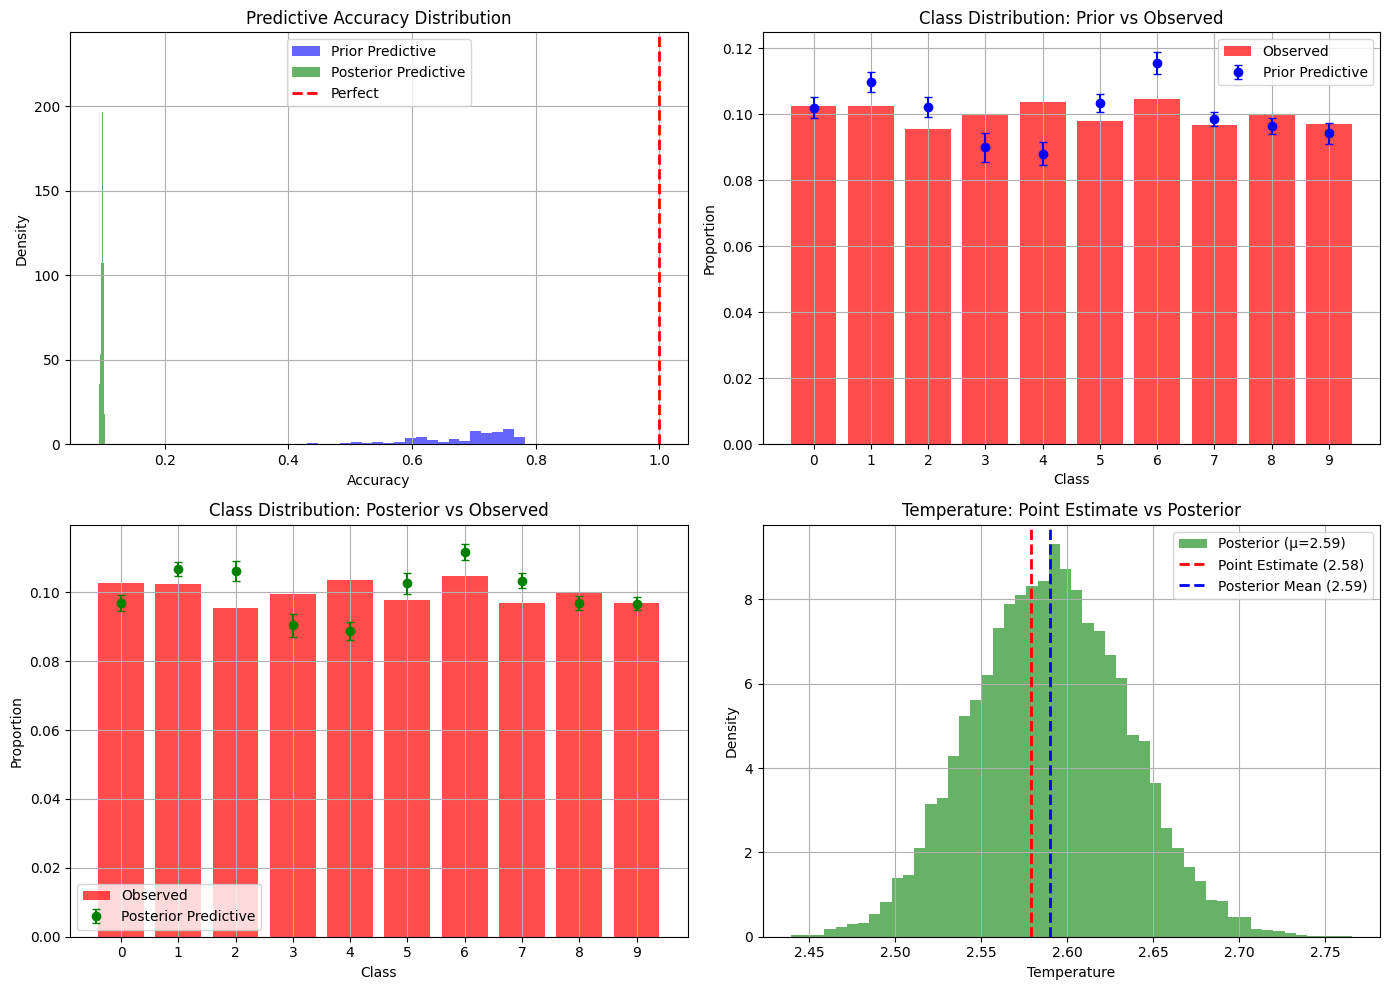

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(prior_accuracies, bins=20, alpha=0.6, label='Prior Predictive', density=True, color='blue')
axes[0, 0].hist(posterior_accuracies, bins=20, alpha=0.6, label='Posterior Predictive', density=True, color='green')
axes[0, 0].axvline(1.0, color='red', linestyle='--', linewidth=2, label='Perfect')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Predictive Accuracy Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].bar(range(n_classes), observed_dist, alpha=0.7, label='Observed', color='red')
axes[0, 1].errorbar(range(n_classes), np.mean(prior_dists, axis=0), 
                    yerr=np.std(prior_dists, axis=0), fmt='o', 
                    label='Prior Predictive', color='blue', capsize=3)
axes[0, 1].set_xlabel('Class')
axes[0, 1].set_ylabel('Proportion')
axes[0, 1].set_title('Class Distribution: Prior vs Observed')
axes[0, 1].legend()
axes[0, 1].grid(True)
axes[0, 1].set_xticks(range(n_classes))

axes[1, 0].bar(range(n_classes), observed_dist, alpha=0.7, label='Observed', color='red')
axes[1, 0].errorbar(range(n_classes), np.mean(posterior_dists, axis=0), 
                    yerr=np.std(posterior_dists, axis=0), fmt='o', 
                    label='Posterior Predictive', color='green', capsize=3)
axes[1, 0].set_xlabel('Class')
axes[1, 0].set_ylabel('Proportion')
axes[1, 0].set_title('Class Distribution: Posterior vs Observed')
axes[1, 0].legend()
axes[1, 0].grid(True)
axes[1, 0].set_xticks(range(n_classes))

axes[1, 1].hist(temp_samples_from_trace, bins=50, alpha=0.6, label=f'Posterior (μ={mean_temp_bayesian:.2f})', 
               density=True, color='green')
axes[1, 1].axvline(calibrated_temp, color='red', linestyle='--', linewidth=2, 
                   label=f'Point Estimate ({calibrated_temp:.2f})')
axes[1, 1].axvline(mean_temp_bayesian, color='blue', linestyle='--', linewidth=2, 
                   label=f'Posterior Mean ({mean_temp_bayesian:.2f})')
axes[1, 1].set_xlabel('Temperature')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Temperature: Point Estimate vs Posterior')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [64]:
def generate_predictions_fixed_temp(logits, temp):
    scaled_logits = logits / temp
    probs = F.softmax(torch.tensor(scaled_logits), dim=1).numpy()
    preds = np.argmax(probs, axis=1)
    return preds, probs

def compute_cross_entropy(probs, labels):
    one_hot = np.eye(10)[labels]
    return -np.mean(np.sum(one_hot * np.log(probs + 1e-10), axis=1))

preds_fixed, probs_fixed = generate_predictions_fixed_temp(logits_val, calibrated_temp)
preds_bayesian_mean, probs_bayesian_mean = generate_predictions_fixed_temp(logits_val, mean_temp_bayesian)

acc_fixed = compute_accuracy(preds_fixed, labels_val_np)
acc_bayesian_mean = compute_accuracy(preds_bayesian_mean, labels_val_np)
ce_fixed = compute_cross_entropy(probs_fixed, labels_val_np)
ce_bayesian_mean = compute_cross_entropy(probs_bayesian_mean, labels_val_np)

print('Validation Set Comparison:')
print(f'Model 1: Fixed τ = {calibrated_temp:.4f} (Point Estimate)')
print(f'  Accuracy: {acc_fixed:.4f}')
print(f'  Cross-Entropy: {ce_fixed:.4f}')
print(f'\nModel 2: Bayesian τ = {mean_temp_bayesian:.4f} (Posterior Mean)')
print(f'  Accuracy: {acc_bayesian_mean:.4f}')
print(f'  Cross-Entropy: {ce_bayesian_mean:.4f}')
print(f'\nDifference (Bayesian - Fixed):')
print(f'  Accuracy: {acc_bayesian_mean - acc_fixed:+.4f}')
print(f'  Cross-Entropy: {ce_bayesian_mean - ce_fixed:+.4f}')


Validation Set Comparison:
Model 1: Fixed τ = 2.5791 (Point Estimate)
  Accuracy: 0.7800
  Cross-Entropy: 0.6503

Model 2: Bayesian τ = 2.5902 (Posterior Mean)
  Accuracy: 0.7800
  Cross-Entropy: 0.6502

Difference (Bayesian - Fixed):
  Accuracy: +0.0000
  Cross-Entropy: -0.0000


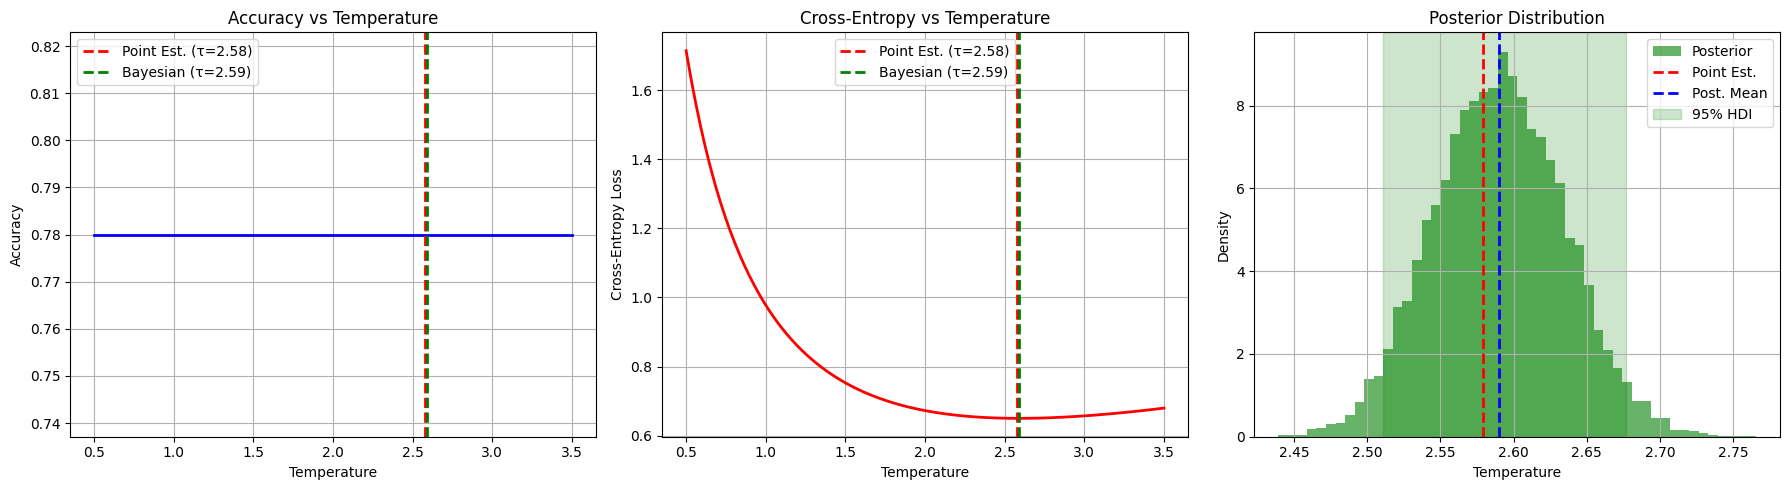

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

temp_range = np.linspace(0.5, 3.5, 100)
accuracies = []
cross_entropies = []

for temp in temp_range:
    preds_temp, probs_temp = generate_predictions_fixed_temp(logits_val, temp)
    accuracies.append(compute_accuracy(preds_temp, labels_val_np))
    cross_entropies.append(compute_cross_entropy(probs_temp, labels_val_np))

axes[0].plot(temp_range, accuracies, 'b-', linewidth=2)
axes[0].axvline(calibrated_temp, color='red', linestyle='--', linewidth=2, label=f'Point Est. (τ={calibrated_temp:.2f})')
axes[0].axvline(mean_temp_bayesian, color='green', linestyle='--', linewidth=2, label=f'Bayesian (τ={mean_temp_bayesian:.2f})')
axes[0].set_xlabel('Temperature')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy vs Temperature')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(temp_range, cross_entropies, 'r-', linewidth=2)
axes[1].axvline(calibrated_temp, color='red', linestyle='--', linewidth=2, label=f'Point Est. (τ={calibrated_temp:.2f})')
axes[1].axvline(mean_temp_bayesian, color='green', linestyle='--', linewidth=2, label=f'Bayesian (τ={mean_temp_bayesian:.2f})')
axes[1].set_xlabel('Temperature')
axes[1].set_ylabel('Cross-Entropy Loss')
axes[1].set_title('Cross-Entropy vs Temperature')
axes[1].legend()
axes[1].grid(True)

axes[2].hist(temp_samples_from_trace, bins=50, alpha=0.6, density=True, color='green', label='Posterior')
axes[2].axvline(calibrated_temp, color='red', linestyle='--', linewidth=2, label=f'Point Est.')
axes[2].axvline(mean_temp_bayesian, color='blue', linestyle='--', linewidth=2, label=f'Post. Mean')
axes[2].axvspan(hdi.temperature.values[0], hdi.temperature.values[1], alpha=0.2, color='green', label='95% HDI')
axes[2].set_xlabel('Temperature')
axes[2].set_ylabel('Density')
axes[2].set_title('Posterior Distribution')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


In [66]:
# Debug: Check what L-BFGS actually optimized
print("Diagnostic Check:")
print(f"calibrated_temp value: {calibrated_temp}")

# Re-compute CE using the same method as L-BFGS
with torch.no_grad():
    logits_torch = torch.tensor(logits_val)
    labels_torch = torch.tensor(labels_val_np)
    
    # Method 1: PyTorch CrossEntropyLoss (what L-BFGS used)
    ce_pytorch_fixed = F.cross_entropy(logits_torch / calibrated_temp, labels_torch).item()
    ce_pytorch_bayesian = F.cross_entropy(logits_torch / mean_temp_bayesian, labels_torch).item()
    
    print(f"\nPyTorch CrossEntropyLoss:")
    print(f"  τ={calibrated_temp:.4f}: {ce_pytorch_fixed:.4f}")
    print(f"  τ={mean_temp_bayesian:.4f}: {ce_pytorch_bayesian:.4f}")
    
    # Method 2: Manual computation
    print(f"\nManual computation (from Cell 14):")
    print(f"  τ={calibrated_temp:.4f}: {ce_fixed:.4f}")
    print(f"  τ={mean_temp_bayesian:.4f}: {ce_bayesian_mean:.4f}")
    
    # Check if they match
    print(f"\nDo they match?")
    print(f"  PyTorch vs Manual (fixed): {abs(ce_pytorch_fixed - ce_fixed) < 0.001}")
    print(f"  PyTorch vs Manual (bayesian): {abs(ce_pytorch_bayesian - ce_bayesian_mean) < 0.001}")


Diagnostic Check:
calibrated_temp value: 2.579084873199463

PyTorch CrossEntropyLoss:
  τ=2.5791: 0.6503
  τ=2.5902: 0.6502

Manual computation (from Cell 14):
  τ=2.5791: 0.6503
  τ=2.5902: 0.6502

Do they match?
  PyTorch vs Manual (fixed): True
  PyTorch vs Manual (bayesian): True
